In [287]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import scipy.stats as stats
from scipy.stats import pearsonr

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

In [298]:
df = pd.read_csv("master_df.csv")

In [288]:
r=df.columns
for i in r:
    print("'",i,"'has these many uniques",df[i].nunique())

' date 'has these many uniques 372
' price 'has these many uniques 3622
' bedrooms 'has these many uniques 12
' bathrooms 'has these many uniques 29
' sqft_living 'has these many uniques 1034
' sqft_lot 'has these many uniques 9776
' floors 'has these many uniques 6
' waterfront 'has these many uniques 2
' view 'has these many uniques 5
' condition 'has these many uniques 5
' grade 'has these many uniques 11
' sqft_above 'has these many uniques 942
' sqft_basement 'has these many uniques 303
' yr_built 'has these many uniques 116
' yr_renovated 'has these many uniques 70
' zipcode 'has these many uniques 70
' lat 'has these many uniques 5033
' long 'has these many uniques 751
' sqft_living15 'has these many uniques 777
' sqft_lot15 'has these many uniques 8682
' basement 'has these many uniques 2
' year 'has these many uniques 2
' Renovated 'has these many uniques 2
' age_when_sold 'has these many uniques 117
' month 'has these many uniques 12


In [289]:
df.drop(columns='date', inplace=True) #dropping date 

In [290]:
df.dtypes

price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement    float64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
basement           int64
year               int64
Renovated          int64
age_when_sold      int64
month              int64
dtype: object

In [11]:
X = df
y = df['price']

In [12]:
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.35,random_state=0)

In [13]:
lr=LinearRegression(fit_intercept=True)
model=lr.fit(xtrain,ytrain)
prediction=lr.predict(xtest)
print("Train_Accuracy")
print(lr.score(xtrain,ytrain))
print("Test_Accuracy")
print(lr.score(xtest,ytest))

Train_Accuracy
1.0
Test_Accuracy
1.0


In [14]:
df['age'] = 2020-df['yr_built']

skewness : 4.023364652271239
kurtosis : 34.54135857673376


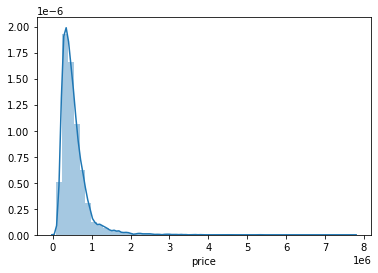

In [15]:
sns.distplot(df['price'])
print("skewness :", df['price'].skew())
print("kurtosis :",df['price'].kurt())

In [16]:
df_boxplot = df[['sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15', 'age']]
df_barplot = df[['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'grade']]

boxplot of sqft_living


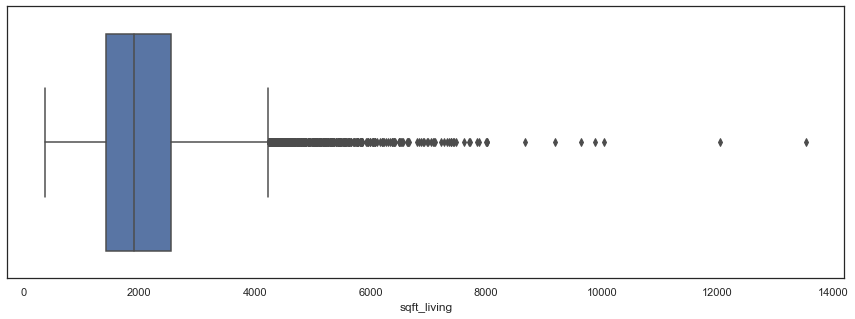

boxplot of sqft_above


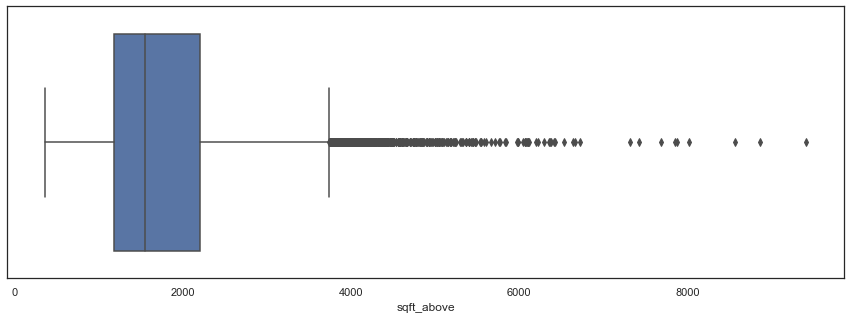

boxplot of sqft_basement


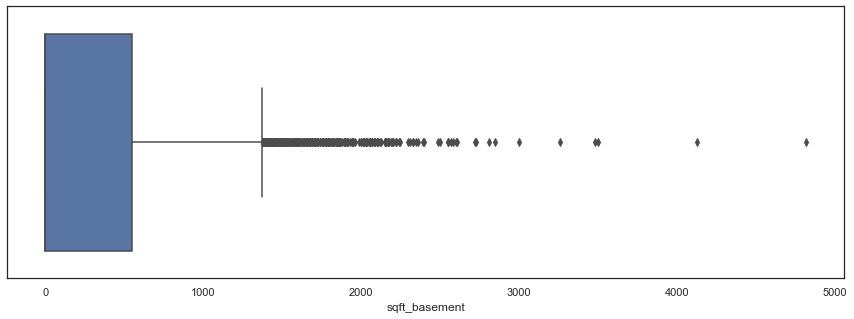

boxplot of sqft_living15


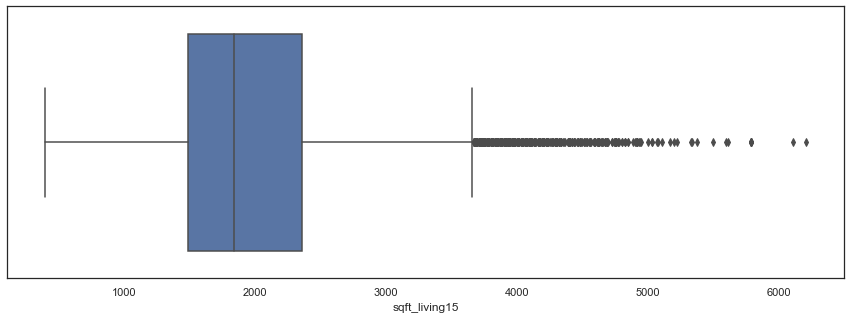

boxplot of age


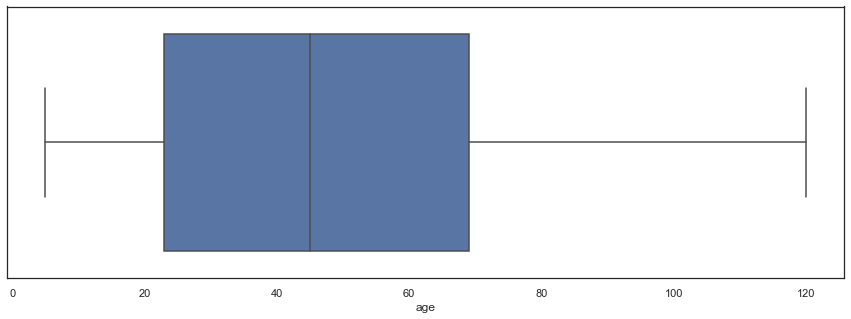

In [17]:
for i in df_boxplot.columns:
    sns.set(style='white')
    plt.figure(figsize=(15,5))
    print("boxplot of %s" %(i))
    sns.boxplot(x=i, data=df)
    plt.show()

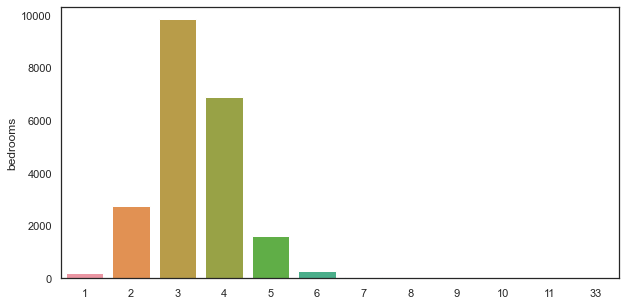

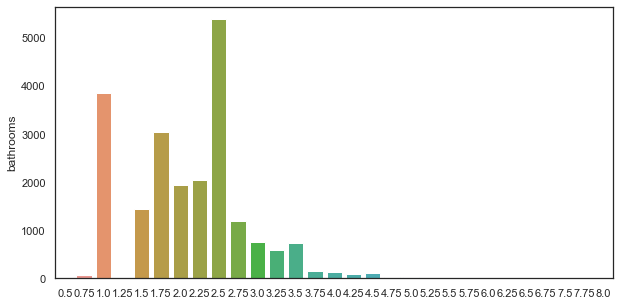

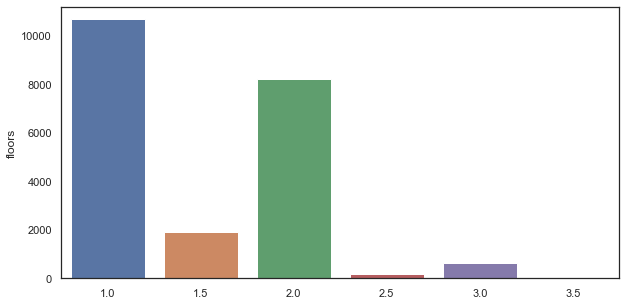

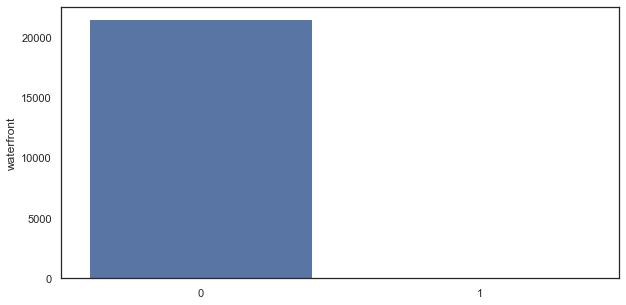

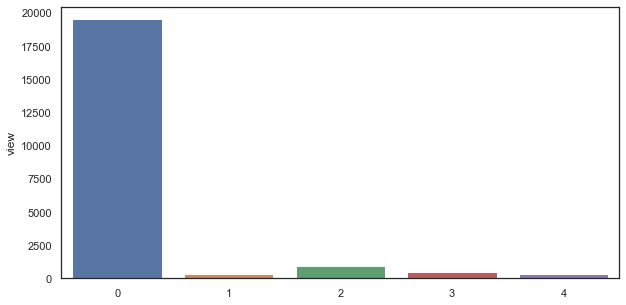

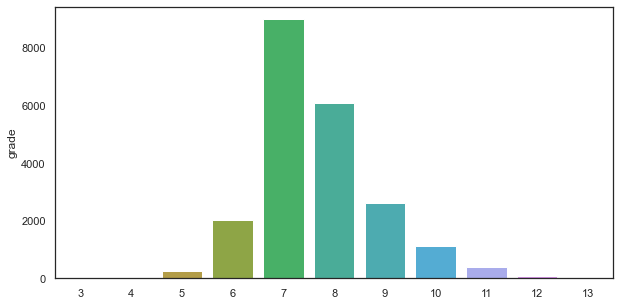

In [21]:
for i in df_barplot.columns:
    plt.figure(figsize=(10,5))
    cat_num = df[i].value_counts()
    sns.barplot(x=cat_num.index, y=cat_num)
    plt.show()

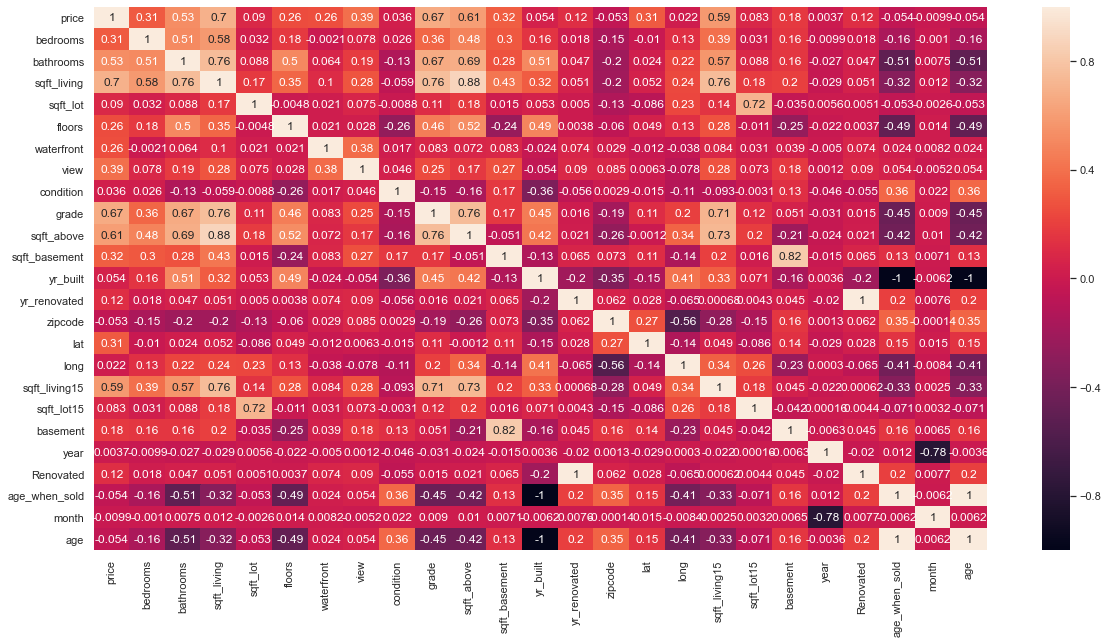

In [22]:
sns.set()
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True)

The heatmap above suggests following independent variables don't affect the price much:

* sqft_lot
* condition
* yr_renovated
* zipcode
* long
* sqft_lot15

Dropping above columns

In [299]:
df.head()

date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  2014-10-13  221900.0         3       1.00         1180      5650     1.0   
1  2014-12-09  538000.0         3       2.25         2570      7242     2.0   
2  2015-02-25  180000.0         2       1.00          770     10000     1.0   
3  2014-12-09  604000.0         4       3.00         1960      5000     1.0   
4  2015-02-18  510000.0         3       2.00         1680      8080     1.0   

   waterfront  view  condition  ...  zipcode      lat     long  sqft_living15  \
0           0     0          3  ...    98178  47.5112 -122.257           1340   
1           0     0          3  ...    98125  47.7210 -122.319           1690   
2           0     0          3  ...    98028  47.7379 -122.233           2720   
3           0     0          5  ...    98136  47.5208 -122.393           1360   
4           0     0          3  ...    98074  47.6168 -122.045           1800   

   sqft_lot15  basement  year  Renovated  age_when_sold  month  
0        5650         0  2014          0             59     10  
1        7639         1  2014          1             63     12  
2        8062         0  2015          0             82      2  
3        5000         1  2014          0             49     12  
4        7503         0  2015          0             28      2  

[5 rows x 25 columns]

## Removing and checking for outliers

In [300]:
# Identify the outliers 4 sd away from mean.
def remove_outliers(df, column_name, threshold=4):
    z_scores = stats.zscore(df[column_name])
    indices = np.abs(np.where(z_scores > threshold))
    return indices[0]
    
columns_to_check = ['price', 'sqft_living', 'bedrooms', 'bathrooms', 
                   'sqft_living15','sqft_basement','grade']

all_indices = []
for column in columns_to_check:
    indices = remove_outliers(df, column, threshold=4)
    all_indices.extend(indices)
all_indices = np.unique(all_indices)

In [301]:
df = df.drop(index=all_indices)
df.shape

(21252, 25)

In [302]:
df.drop(columns = 'sqft_living')

date     price  bedrooms  bathrooms  sqft_lot  floors  \
0      2014-10-13  221900.0         3       1.00      5650     1.0   
1      2014-12-09  538000.0         3       2.25      7242     2.0   
2      2015-02-25  180000.0         2       1.00     10000     1.0   
3      2014-12-09  604000.0         4       3.00      5000     1.0   
4      2015-02-18  510000.0         3       2.00      8080     1.0   
...           ...       ...       ...        ...       ...     ...   
21592  2014-05-21  360000.0         3       2.50      1131     3.0   
21593  2015-02-23  400000.0         4       2.50      5813     2.0   
21594  2014-06-23  402101.0         2       0.75      1350     2.0   
21595  2015-01-16  400000.0         3       2.50      2388     2.0   
21596  2014-10-15  325000.0         2       0.75      1076     2.0   

       waterfront  view  condition  grade  ...  zipcode      lat     long  \
0               0     0          3      7  ...    98178  47.5112 -122.257   
1               0     0          3      7  ...    98125  47.7210 -122.319   
2               0     0          3      6  ...    98028  47.7379 -122.233   
3               0     0          5      7  ...    98136  47.5208 -122.393   
4               0     0          3      8  ...    98074  47.6168 -122.045   
...           ...   ...        ...    ...  ...      ...      ...      ...   
21592           0     0          3      8  ...    98103  47.6993 -122.346   
21593           0     0          3      8  ...    98146  47.5107 -122.362   
21594           0     0          3      7  ...    98144  47.5944 -122.299   
21595           0     0          3      8  ...    98027  47.5345 -122.069   
21596           0     0          3      7  ...    98144  47.5941 -122.299   

       sqft_living15  sqft_lot15  basement  year  Renovated  age_when_sold  \
0               1340        5650         0  2014          0             59   
1               1690        7639         1  2014          1             63   
2               2720        8062         0  2015          0             82   
3               1360        5000         1  2014          0             49   
4               1800        7503         0  2015          0             28   
...              ...         ...       ...   ...        ...            ...   
21592           1530        1509         0  2014          0              5   
21593           1830        7200         0  2015          0              1   
21594           1020        2007         0  2014          0              5   
21595           1410        1287         0  2015          0             11   
21596           1020        1357         0  2014          0              6   

       month  
0         10  
1         12  
2          2  
3         12  
4          2  
...      ...  
21592      5  
21593      2  
21594      6  
21595      1  
21596     10  

[21252 rows x 24 columns]

## Normalize using zscores

In [304]:
df.price = (df.price - df.price.mean()) / df.price.std()
df.sqft_lot = (df.sqft_lot - df.sqft_lot.mean()) / df.sqft_lot.std()
df.bedrooms = (df.bedrooms - df.bedrooms.mean()) / df.bedrooms.std()
df.bathrooms = (df.bathrooms - df.bathrooms.mean()) / df.bathrooms.std()
df.floors = (df.floors - df.floors.mean()) /df.floors.std()
df.sqft_above = (df.sqft_above - df.sqft_above.mean()) / df.sqft_above.std()
df.sqft_basement = (df.sqft_basement - df.sqft_basement.mean()) / df.sqft_basement.std()
df.sqft_living15 = (df.sqft_living15 - df.sqft_living15.mean()) / df.sqft_living15.std()
df.sqft_lot15 = (df.sqft_lot15 - df.sqft_lot15.mean()) / df.sqft_lot15.std()

df.head()

date     price  bedrooms  bathrooms  sqft_living  sqft_lot    floors  \
0  2014-10-13 -1.044668 -0.399029  -1.490566         1180 -0.224035 -0.907297   
1  2014-12-09  0.083455 -0.399029   0.222788         2570 -0.184853  0.947978   
2  2015-02-25 -1.194204 -1.538990  -1.490566          770 -0.116974 -0.907297   
3  2014-12-09  0.319001  0.740932   1.250800         1960 -0.240033 -0.907297   
4  2015-02-18 -0.016474 -0.399029  -0.119883         1680 -0.164229 -0.907297   

   waterfront  view  condition  ...  zipcode      lat     long  sqft_living15  \
0           0     0          3  ...    98178  47.5112 -122.257      -0.957936   
1           0     0          3  ...    98125  47.7210 -122.319      -0.418295   
2           0     0          3  ...    98028  47.7379 -122.233       1.169794   
3           0     0          5  ...    98136  47.5208 -122.393      -0.927100   
4           0     0          3  ...    98074  47.6168 -122.045      -0.248693   

   sqft_lot15  basement  year  Renovated  age_when_sold  month  
0   -0.260221         0  2014          0             59     10  
1   -0.184605         1  2014          1             63     12  
2   -0.168524         0  2015          0             82      2  
3   -0.284932         1  2014          0             49     12  
4   -0.189775         0  2015          0             28      2  

[5 rows x 25 columns]

## Modelling

In [314]:
# Build a multiple linear regression model
df_features = pd.DataFrame(data=df, columns = None)
df_features = df.drop(['date', 'price', 'yr_built', 'yr_renovated', 'waterfront', 
                        'zipcode', 'lat', 'long', 'basement', 'Renovated'],axis=1)

X = df_features
y = df['price']


In [315]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=33)

In [316]:
model = LinearRegression()
model.fit(X_train,y_train)
predictions = model.predict(X_test)

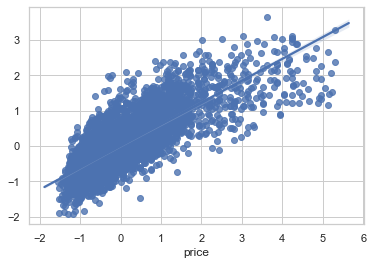

In [317]:
sns.set_style("whitegrid")
sns.regplot(y_test,predictions)

In [318]:
print("score : ",r2_score(y_test,predictions))

score :  0.6266787142492767


In [321]:
X.head()

bedrooms  bathrooms  sqft_living  sqft_lot    floors  view  condition  \
0 -0.399029  -1.490566         1180 -0.224035 -0.907297     0          3   
1 -0.399029   0.222788         2570 -0.184853  0.947978     0          3   
2 -1.538990  -1.490566          770 -0.116974 -0.907297     0          3   
3  0.740932   1.250800         1960 -0.240033 -0.907297     0          5   
4 -0.399029  -0.119883         1680 -0.164229 -0.907297     0          3   

   grade  sqft_above  sqft_basement  sqft_living15  sqft_lot15  year  \
0      7   -0.747270      -0.656273      -0.957936   -0.260221  2014   
1      7    0.542665       0.306139      -0.418295   -0.184605  2014   
2      6   -1.281486      -0.656273       1.169794   -0.168524  2015   
3      7   -0.916656       1.533214      -0.927100   -0.284932  2014   
4      8   -0.095788      -0.656273      -0.248693   -0.189775  2015   

   age_when_sold  month  
0             59     10  
1             63     12  
2             82      2  
3             49     12  
4             28      2

In [322]:
sk_ols = LinearRegression(fit_intercept=False, normalize=False, n_jobs=-1)

In [323]:
def make_ols_sklearn(X, y, test_size=0.20, fit_intercept=False, standardize=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    if standardize:
        ss = StandardScaler()
        ss.fit(X_train)
        X_train = ss.transform(X_train)
        X_test = ss.transform(X_test)
    ols = LinearRegression(fit_intercept=fit_intercept, normalize=False)
    ols.fit(X_train, y_train)
    train_score = ols.score(X_train, y_train)
    test_score = ols.score(X_test, y_test)
    print(f"train score = {train_score}")
    print(f"test score = {test_score}")
    return ols

In [329]:
make_ols_sklearn(X, y)

train score = 0.6305887990340862
test score = 0.6219534952894181


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [325]:
cv_scores = cross_val_score(sk_ols, X, y, scoring='r2', cv=10, n_jobs=-1) 
cv_scores

array([0.63216518, 0.64739504, 0.61029518, 0.61372123, 0.63662496,
       0.63032332, 0.64875545, 0.63013251, 0.62749586, 0.55874467])

In [326]:
target ='price'

In [327]:
train, test = train_test_split(df)

In [328]:
predictors = '+'.join(X)
formula = target + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     1819.
Date:                Thu, 04 Jun 2020   Prob (F-statistic):               0.00
Time:                        13:51:36   Log-Likelihood:                -14751.
No. Observations:               15939   AIC:                         2.953e+04
Df Residuals:                   15923   BIC:                         2.966e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -149.0834     33.686     -4.426      0.000    -215.112     -83.055
bedrooms         -0.0784      0.006    -12.415      0.000      -0.091      -0.066
bathrooms         0.0982      0.009     11.446      0.000       0.081       0.115
sqft_living       0.0002   6.84e-05      3.647      0.000       0.000       0.000
sqft_lot          0.0130      0.007      1.890      0.059      -0.000       0.026
floors            0.0914      0.007     13.480      0.000       0.078       0.105
view              0.1720      0.007     23.947      0.000       0.158       0.186
condition         0.0746      0.008      9.174      0.000       0.059       0.090
grade             0.4119      0.008     54.727      0.000       0.397       0.427
sqft_above        0.0720      0.052      1.378      0.168      -0.030       0.174
sqft_basement     0.0727      0.028      2.586      0.010       0.018       0.128
sqft_living15     0.0924      0.008     11.499      0.000       0.077       0.108
sqft_lot15       -0.0358      0.007     -5.262      0.000      -0.049      -0.022
year              0.0718      0.017      4.296      0.000       0.039       0.105
age_when_sold     0.0115      0.000     51.712      0.000       0.011       0.012
month           4.44e-05      0.003      0.018      0.986      -0.005       0.005
==============================================================================
Omnibus:                     3889.659   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17248.333
Skew:                           1.130   Prob(JB):                         0.00
Kurtosis:                       7.568   Cond. No.                     2.04e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
resid = model.resid

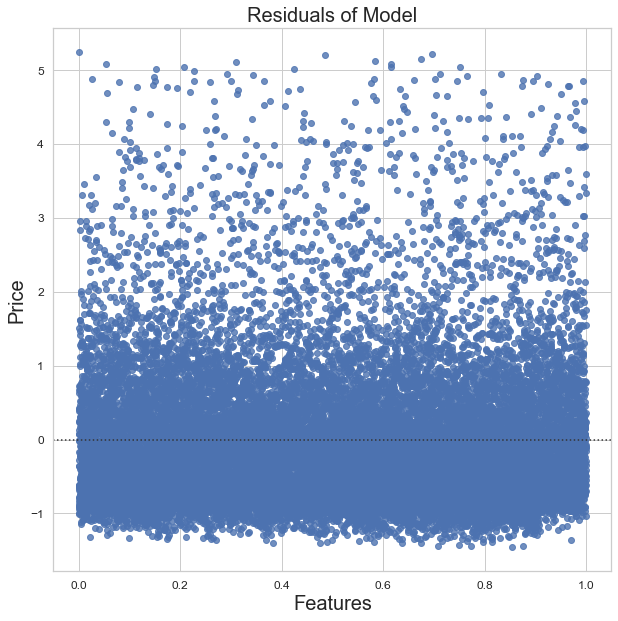

In [332]:
# Check residuals using sns.residplot
y_hat = linreg.predict()
residuals = df['price'] - y_hat
x_vals = np.linspace(0, 1, len(residuals))

plt.figure(figsize=(10,10))
sns.residplot(x_vals, residuals, data = df, color='b')
plt.title('Residuals of Model', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)
plt.show()

## RFE method

In [270]:
rfe = RFE(sk_ols, n_features_to_select=5, step=1, verbose=2)

In [271]:
X_all = df.drop(columns=['price'])

In [272]:
rfe.fit(X_all, df['price'])

Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.


RFE(estimator=LinearRegression(copy_X=True, fit_intercept=False, n_jobs=-1,
                               normalize=False),
    n_features_to_select=5, step=1, verbose=2)

In [273]:

new_cols = X_all.columns[rfe.support_]

In [274]:
X_new = df[new_cols]
X_new.head()

bedrooms  bathrooms  yr_built  year  age_when_sold
0         3       1.00      1955  2014             59
1         3       2.25      1951  2014             63
2         2       1.00      1933  2015             82
3         4       3.00      1965  2014             49
4         3       2.00      1987  2015             28

In [277]:
y1 = np.log(df['price']) #trying with log value of price

In [278]:

make_ols_sklearn(X_new, y1)

train score = 0.35852666520573706
test score = 0.35971939247238294


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [279]:
cv_scores = cross_val_score(sk_ols, X_new, df['price'], scoring='r2', cv=10, n_jobs=-1) 
cv_scores

array([0.33173739, 0.337458  , 0.32526568, 0.34259144, 0.30677153,
       0.34906745, 0.35091183, 0.34132865, 0.34504844, 0.31793277])